In [2]:
import sys
sys.path.append('../')
from models import VGAE, LatentMLP 
from utils import BrainGraphDataset, project_root, get_data_labels
import torch
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root = project_root()

# instantiate the VGAE model
lr = 0.001
batch_size = 64

nf = 1
ef = 1
num_nodes = 100
hidden_dim = 128
latent_size = 8

criterion = nn.L1Loss(reduction='sum')
categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

annotations = 'annotations.csv'

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')

dataroot = 'fc_matrices/psilo_ica_100_before/'

dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='lz')

# Define the train, validation, and test ratios
train_ratio = 0.8
val_ratio = 0.2
test_ratio = 0.2

# Get the number of samples in the dataset
num_samples = len(dataset)

# Calculate the number of samples for each set
train_size = int(train_ratio * num_samples)
val_size = num_samples - train_size

torch.manual_seed(0)
# Split the dataset into train, validation, and test sets


import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

# Assuming you have your dataset defined as 'dataset'
num_folds = 5  # Specify the number of folds
batch_size = 8  # Specify your desired batch size
random_seed = 42  # Specify the random seed

# Create indices for k-fold cross-validation with seeded random number generator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

# Create empty lists to store train and validation loaders
train_loaders = []
val_loaders = []

for train_index, val_index in kf.split(dataset):
    # Split dataset into train and validation sets for the current fold
    train_set = torch.utils.data.Subset(dataset, train_index)
    val_set = torch.utils.data.Subset(dataset, val_index)

    # Define the dataloaders for the current fold
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Append the loaders to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)


num_epochs = 500

import json

# Dictionary to store training and validation curves
results = []
dropout_list = [0]
best_set = [0] * num_folds

for i, train_loader in enumerate(train_loaders):
    val_loader = val_loaders[i]
    for dropout in dropout_list:
        vgae = VGAE(1, 1, 100, 64, 4, device, dropout=0, l2_strength=0.001).to(device)
        # load the trained VGAE weights
        vgae.load_state_dict(torch.load(os.path.join(root, 'vgae_weights/vgae_nf_ica.pt'), map_location=device))
        # Convert the model to the device
        vgae.to(device)
        
        best_val_loss = float('inf')  # set to infinity to start
        best_model_state = None
        train_losses = []
        val_losses = []

        model = LatentMLP(64, 64, 1, dropout=dropout)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        src, dest = vgae.edge_index

        for epoch in tqdm(range(num_epochs)):
            train_loss = 0.0
            val_loss = 0.0

            # training
            model.train()
            for batch_idx, ((graph, lz, baseline_bdi), label) in enumerate(train_loader):
                graph = graph.to(device)  # move data to device
                lz = lz.to(device)
                label = label.to(device)
                optimizer.zero_grad()

                rcn_lz, rcn_edges, z, _, _ = vgae(lz, graph)
                graph = graph[:, src, dest]

                output_bdi = model(z.view(z.shape[0], -1), baseline_bdi)

                l1_loss, l2_loss = model.loss(output_bdi, label.view(output_bdi.shape))
                loss = l1_loss + l2_loss
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # validation
            model.eval()
            val_label = []
            val_output = []
            val_base = []
            with torch.no_grad():
                for batch_idx, ((graph, lz, baseline_bdi), label) in enumerate(val_loader):
                    graph = graph.to(device)  # move data to device
                    lz = lz.to(device)
                    label = label.to(device)

                    rcn_lz, rcn_edges, z, _, _ = vgae(lz, graph)
                    graph = graph[:, src, dest]

                    output_bdi = model(z.view(z.shape[0], -1), baseline_bdi)

                    val_label.extend(label)
                    val_output.extend(output_bdi)
                    val_base.extend(baseline_bdi)
                    
                    l1_loss, l2_loss = model.loss(output_bdi, label.view(output_bdi.shape))
                    loss = l1_loss + l2_loss
                    val_loss += loss.item()
            # append losses to lists
            train_losses.append(train_loss/len(train_set))
            val_losses.append(val_loss/len(val_set))

            # save the model if the validation loss is at its minimum
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]

                best_model_state = (copy.deepcopy(vgae.state_dict()), copy.deepcopy(model.state_dict()))
                best_set[i] = (val_label, val_output, val_base)
            # print the losses
            with open('dropout_train.txt', 'a') as f:
                if (epoch + 1) % 20 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')
                f.write(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

        # save the best model for this configuration
#         torch.save(best_model_state[1], os.path.join(root, f'mlp_weights/vgae_model_weight_schaefer_final.pt'))
#         torch.save(best_model_state[0], os.path.join(root, f'mlp_weights/vgae_vgae_weight_schaefer_final.pt'))

#         # add the loss curves to the dictionary
#         loss_curves[f"dropout_{dropout}"] = {"train_loss": train_losses, "val_loss": val_losses}

    
#     # save the loss curves to a file
#     with open("loss_curves_mlp_vgae.json", "w") as f:
#         json.dump(loss_curves, f)

  4%|▍         | 20/500 [00:04<01:50,  4.34it/s]

Epoch 20/500 - Train Loss: 5.6672 - Val Loss: 13.0915



  8%|▊         | 40/500 [00:09<01:41,  4.52it/s]

Epoch 40/500 - Train Loss: 5.5066 - Val Loss: 12.6298



 12%|█▏        | 60/500 [00:13<01:36,  4.55it/s]

Epoch 60/500 - Train Loss: 4.9871 - Val Loss: 12.9516



 16%|█▌        | 80/500 [00:18<01:33,  4.51it/s]

Epoch 80/500 - Train Loss: 4.1599 - Val Loss: 12.7464



 20%|██        | 100/500 [00:22<01:27,  4.55it/s]

Epoch 100/500 - Train Loss: 3.9210 - Val Loss: 12.7289



 24%|██▍       | 120/500 [00:26<01:23,  4.57it/s]

Epoch 120/500 - Train Loss: 3.7135 - Val Loss: 13.4381



 28%|██▊       | 140/500 [00:31<01:20,  4.49it/s]

Epoch 140/500 - Train Loss: 3.4942 - Val Loss: 13.1475



 32%|███▏      | 160/500 [00:35<01:14,  4.57it/s]

Epoch 160/500 - Train Loss: 3.6784 - Val Loss: 12.9528



 36%|███▌      | 180/500 [00:39<01:09,  4.58it/s]

Epoch 180/500 - Train Loss: 3.5555 - Val Loss: 12.2460



 40%|████      | 200/500 [00:44<01:05,  4.57it/s]

Epoch 200/500 - Train Loss: 3.2391 - Val Loss: 11.7005



 44%|████▍     | 220/500 [00:48<01:01,  4.58it/s]

Epoch 220/500 - Train Loss: 3.1673 - Val Loss: 13.1906



 48%|████▊     | 240/500 [00:53<00:56,  4.58it/s]

Epoch 240/500 - Train Loss: 3.0843 - Val Loss: 12.3476



 52%|█████▏    | 260/500 [00:57<00:52,  4.57it/s]

Epoch 260/500 - Train Loss: 3.3758 - Val Loss: 12.7664



 56%|█████▌    | 280/500 [01:01<00:48,  4.58it/s]

Epoch 280/500 - Train Loss: 2.8492 - Val Loss: 12.3205



 60%|██████    | 300/500 [01:06<00:43,  4.56it/s]

Epoch 300/500 - Train Loss: 2.8062 - Val Loss: 11.8150



 64%|██████▍   | 320/500 [01:10<00:39,  4.58it/s]

Epoch 320/500 - Train Loss: 2.4941 - Val Loss: 12.2044



 68%|██████▊   | 340/500 [01:14<00:34,  4.58it/s]

Epoch 340/500 - Train Loss: 2.1392 - Val Loss: 11.1681



 72%|███████▏  | 360/500 [01:19<00:30,  4.60it/s]

Epoch 360/500 - Train Loss: 1.9456 - Val Loss: 12.2130



 76%|███████▌  | 380/500 [01:23<00:26,  4.60it/s]

Epoch 380/500 - Train Loss: 2.1340 - Val Loss: 11.4071



 80%|████████  | 400/500 [01:28<00:21,  4.61it/s]

Epoch 400/500 - Train Loss: 2.1718 - Val Loss: 11.7247



 84%|████████▍ | 420/500 [01:32<00:17,  4.58it/s]

Epoch 420/500 - Train Loss: 2.0234 - Val Loss: 12.6978



 88%|████████▊ | 440/500 [01:36<00:12,  4.63it/s]

Epoch 440/500 - Train Loss: 2.4486 - Val Loss: 12.6917



 92%|█████████▏| 460/500 [01:41<00:08,  4.62it/s]

Epoch 460/500 - Train Loss: 2.0240 - Val Loss: 11.2736



 96%|█████████▌| 480/500 [01:45<00:04,  4.60it/s]

Epoch 480/500 - Train Loss: 1.9877 - Val Loss: 11.8560



100%|██████████| 500/500 [01:49<00:00,  4.56it/s]


Epoch 500/500 - Train Loss: 1.9503 - Val Loss: 12.9486



  4%|▍         | 20/500 [00:04<01:43,  4.65it/s]

Epoch 20/500 - Train Loss: 7.0574 - Val Loss: 7.0202



  8%|▊         | 40/500 [00:08<01:39,  4.61it/s]

Epoch 40/500 - Train Loss: 5.8783 - Val Loss: 8.4642



 12%|█▏        | 60/500 [00:12<01:34,  4.64it/s]

Epoch 60/500 - Train Loss: 5.1134 - Val Loss: 9.9618



 16%|█▌        | 80/500 [00:17<01:30,  4.62it/s]

Epoch 80/500 - Train Loss: 4.9293 - Val Loss: 10.5758



 20%|██        | 100/500 [00:21<01:28,  4.54it/s]

Epoch 100/500 - Train Loss: 4.7313 - Val Loss: 9.3260



 24%|██▍       | 120/500 [00:25<01:22,  4.60it/s]

Epoch 120/500 - Train Loss: 4.5432 - Val Loss: 9.4252



 28%|██▊       | 140/500 [00:30<01:18,  4.60it/s]

Epoch 140/500 - Train Loss: 4.1608 - Val Loss: 10.4489



 32%|███▏      | 160/500 [00:34<01:13,  4.60it/s]

Epoch 160/500 - Train Loss: 4.3660 - Val Loss: 9.2765



 36%|███▌      | 180/500 [00:39<01:09,  4.61it/s]

Epoch 180/500 - Train Loss: 4.2747 - Val Loss: 9.4403



 40%|████      | 200/500 [00:43<01:05,  4.61it/s]

Epoch 200/500 - Train Loss: 3.8764 - Val Loss: 10.4986



 44%|████▍     | 220/500 [00:47<01:01,  4.55it/s]

Epoch 220/500 - Train Loss: 3.9126 - Val Loss: 10.0488



 48%|████▊     | 240/500 [00:52<00:56,  4.60it/s]

Epoch 240/500 - Train Loss: 3.9281 - Val Loss: 8.1513



 52%|█████▏    | 260/500 [00:56<00:52,  4.61it/s]

Epoch 260/500 - Train Loss: 3.8718 - Val Loss: 8.9484



 56%|█████▌    | 280/500 [01:00<00:47,  4.63it/s]

Epoch 280/500 - Train Loss: 4.4022 - Val Loss: 10.0516



 60%|██████    | 300/500 [01:05<00:43,  4.61it/s]

Epoch 300/500 - Train Loss: 4.1006 - Val Loss: 10.1888



 64%|██████▍   | 320/500 [01:09<00:39,  4.61it/s]

Epoch 320/500 - Train Loss: 3.8438 - Val Loss: 10.4780



 68%|██████▊   | 340/500 [01:13<00:34,  4.61it/s]

Epoch 340/500 - Train Loss: 3.5422 - Val Loss: 10.5354



 72%|███████▏  | 360/500 [01:18<00:30,  4.58it/s]

Epoch 360/500 - Train Loss: 3.4361 - Val Loss: 9.4686



 76%|███████▌  | 380/500 [01:22<00:26,  4.55it/s]

Epoch 380/500 - Train Loss: 3.6772 - Val Loss: 8.3656



 80%|████████  | 400/500 [01:26<00:21,  4.56it/s]

Epoch 400/500 - Train Loss: 3.3827 - Val Loss: 10.0453



 84%|████████▍ | 420/500 [01:31<00:17,  4.61it/s]

Epoch 420/500 - Train Loss: 3.8591 - Val Loss: 10.0213



 88%|████████▊ | 440/500 [01:35<00:12,  4.62it/s]

Epoch 440/500 - Train Loss: 3.5619 - Val Loss: 9.4728



 92%|█████████▏| 460/500 [01:39<00:08,  4.63it/s]

Epoch 460/500 - Train Loss: 3.4683 - Val Loss: 7.8549



 96%|█████████▌| 480/500 [01:44<00:04,  4.63it/s]

Epoch 480/500 - Train Loss: 3.3895 - Val Loss: 8.4504



100%|██████████| 500/500 [01:48<00:00,  4.61it/s]


Epoch 500/500 - Train Loss: 3.5841 - Val Loss: 10.4903



  4%|▍         | 20/500 [00:04<01:42,  4.68it/s]

Epoch 20/500 - Train Loss: 7.3014 - Val Loss: 6.0141



  8%|▊         | 40/500 [00:08<01:38,  4.69it/s]

Epoch 40/500 - Train Loss: 6.8496 - Val Loss: 5.9529



 12%|█▏        | 60/500 [00:12<01:33,  4.69it/s]

Epoch 60/500 - Train Loss: 5.8451 - Val Loss: 6.4330



 16%|█▌        | 80/500 [00:17<01:29,  4.70it/s]

Epoch 80/500 - Train Loss: 5.2099 - Val Loss: 6.4524



 20%|██        | 100/500 [00:21<01:25,  4.70it/s]

Epoch 100/500 - Train Loss: 4.8200 - Val Loss: 6.2988



 24%|██▍       | 120/500 [00:25<01:20,  4.70it/s]

Epoch 120/500 - Train Loss: 4.4367 - Val Loss: 6.3650



 28%|██▊       | 140/500 [00:29<01:16,  4.69it/s]

Epoch 140/500 - Train Loss: 4.2240 - Val Loss: 6.1995



 32%|███▏      | 160/500 [00:34<01:12,  4.70it/s]

Epoch 160/500 - Train Loss: 4.3617 - Val Loss: 6.0714



 36%|███▌      | 180/500 [00:38<01:07,  4.71it/s]

Epoch 180/500 - Train Loss: 4.0279 - Val Loss: 6.1803



 40%|████      | 200/500 [00:42<01:04,  4.68it/s]

Epoch 200/500 - Train Loss: 4.0785 - Val Loss: 6.0655



 44%|████▍     | 220/500 [00:46<00:59,  4.70it/s]

Epoch 220/500 - Train Loss: 4.1554 - Val Loss: 5.5368



 48%|████▊     | 240/500 [00:51<00:55,  4.69it/s]

Epoch 240/500 - Train Loss: 3.5624 - Val Loss: 5.7816



 52%|█████▏    | 260/500 [00:55<00:50,  4.71it/s]

Epoch 260/500 - Train Loss: 3.4352 - Val Loss: 6.3493



 56%|█████▌    | 280/500 [00:59<00:46,  4.70it/s]

Epoch 280/500 - Train Loss: 2.9673 - Val Loss: 7.9228



 60%|██████    | 300/500 [01:03<00:42,  4.71it/s]

Epoch 300/500 - Train Loss: 3.5016 - Val Loss: 7.0196



 64%|██████▍   | 320/500 [01:08<00:38,  4.69it/s]

Epoch 320/500 - Train Loss: 3.0977 - Val Loss: 6.0991



 68%|██████▊   | 340/500 [01:12<00:34,  4.70it/s]

Epoch 340/500 - Train Loss: 2.8712 - Val Loss: 7.5298



 72%|███████▏  | 360/500 [01:16<00:29,  4.70it/s]

Epoch 360/500 - Train Loss: 3.2729 - Val Loss: 6.8337



 76%|███████▌  | 380/500 [01:20<00:25,  4.69it/s]

Epoch 380/500 - Train Loss: 2.3560 - Val Loss: 8.1027



 80%|████████  | 400/500 [01:25<00:21,  4.69it/s]

Epoch 400/500 - Train Loss: 2.8328 - Val Loss: 8.2053



 84%|████████▍ | 420/500 [01:29<00:17,  4.54it/s]

Epoch 420/500 - Train Loss: 2.7008 - Val Loss: 7.6788



 88%|████████▊ | 440/500 [01:33<00:12,  4.71it/s]

Epoch 440/500 - Train Loss: 2.2962 - Val Loss: 6.2298



 92%|█████████▏| 460/500 [01:38<00:08,  4.71it/s]

Epoch 460/500 - Train Loss: 2.0641 - Val Loss: 6.4829



 96%|█████████▌| 480/500 [01:42<00:04,  4.71it/s]

Epoch 480/500 - Train Loss: 1.8760 - Val Loss: 8.4422



100%|██████████| 500/500 [01:46<00:00,  4.69it/s]


Epoch 500/500 - Train Loss: 1.8284 - Val Loss: 6.9147



  4%|▍         | 20/500 [00:04<01:42,  4.69it/s]

Epoch 20/500 - Train Loss: 7.1888 - Val Loss: 6.4827



  8%|▊         | 40/500 [00:08<01:38,  4.69it/s]

Epoch 40/500 - Train Loss: 6.9082 - Val Loss: 7.5938



 12%|█▏        | 60/500 [00:12<01:34,  4.68it/s]

Epoch 60/500 - Train Loss: 5.6969 - Val Loss: 6.4250



 16%|█▌        | 80/500 [00:17<01:29,  4.68it/s]

Epoch 80/500 - Train Loss: 5.4376 - Val Loss: 7.8077



 20%|██        | 100/500 [00:21<01:25,  4.67it/s]

Epoch 100/500 - Train Loss: 4.9834 - Val Loss: 8.1305



 24%|██▍       | 120/500 [00:25<01:24,  4.52it/s]

Epoch 120/500 - Train Loss: 4.5779 - Val Loss: 8.2956



 28%|██▊       | 140/500 [00:30<01:17,  4.63it/s]

Epoch 140/500 - Train Loss: 4.3981 - Val Loss: 8.0874



 32%|███▏      | 160/500 [00:34<01:13,  4.63it/s]

Epoch 160/500 - Train Loss: 4.1520 - Val Loss: 8.9940



 36%|███▌      | 180/500 [00:38<01:09,  4.63it/s]

Epoch 180/500 - Train Loss: 4.3381 - Val Loss: 7.5516



 40%|████      | 200/500 [00:42<01:04,  4.67it/s]

Epoch 200/500 - Train Loss: 4.2751 - Val Loss: 7.7419



 44%|████▍     | 220/500 [00:47<00:59,  4.68it/s]

Epoch 220/500 - Train Loss: 3.6957 - Val Loss: 7.8771



 48%|████▊     | 240/500 [00:51<00:55,  4.69it/s]

Epoch 240/500 - Train Loss: 3.7030 - Val Loss: 8.4839



 52%|█████▏    | 260/500 [00:55<00:51,  4.69it/s]

Epoch 260/500 - Train Loss: 3.4635 - Val Loss: 8.4570



 56%|█████▌    | 280/500 [01:00<00:46,  4.71it/s]

Epoch 280/500 - Train Loss: 3.3653 - Val Loss: 10.0282



 60%|██████    | 300/500 [01:04<00:42,  4.73it/s]

Epoch 300/500 - Train Loss: 2.8807 - Val Loss: 9.1507



 64%|██████▍   | 320/500 [01:08<00:38,  4.73it/s]

Epoch 320/500 - Train Loss: 2.9521 - Val Loss: 8.0449



 68%|██████▊   | 340/500 [01:12<00:33,  4.73it/s]

Epoch 340/500 - Train Loss: 2.6082 - Val Loss: 8.2835



 72%|███████▏  | 360/500 [01:17<00:29,  4.72it/s]

Epoch 360/500 - Train Loss: 2.6147 - Val Loss: 12.2353



 76%|███████▌  | 380/500 [01:21<00:25,  4.70it/s]

Epoch 380/500 - Train Loss: 2.7434 - Val Loss: 8.3912



 80%|████████  | 400/500 [01:25<00:21,  4.71it/s]

Epoch 400/500 - Train Loss: 2.3560 - Val Loss: 9.6322



 84%|████████▍ | 420/500 [01:29<00:17,  4.70it/s]

Epoch 420/500 - Train Loss: 2.8964 - Val Loss: 9.3208



 88%|████████▊ | 440/500 [01:34<00:12,  4.72it/s]

Epoch 440/500 - Train Loss: 1.8295 - Val Loss: 9.7696



 92%|█████████▏| 460/500 [01:38<00:08,  4.69it/s]

Epoch 460/500 - Train Loss: 1.8605 - Val Loss: 9.3039



 96%|█████████▌| 480/500 [01:42<00:04,  4.70it/s]

Epoch 480/500 - Train Loss: 2.0006 - Val Loss: 10.8081



100%|██████████| 500/500 [01:46<00:00,  4.68it/s]


Epoch 500/500 - Train Loss: 1.8979 - Val Loss: 9.1900



  4%|▍         | 20/500 [00:04<01:42,  4.68it/s]

Epoch 20/500 - Train Loss: 7.4139 - Val Loss: 6.0210



  8%|▊         | 40/500 [00:08<01:38,  4.66it/s]

Epoch 40/500 - Train Loss: 7.2311 - Val Loss: 5.9937



 12%|█▏        | 60/500 [00:12<01:33,  4.71it/s]

Epoch 60/500 - Train Loss: 7.0635 - Val Loss: 5.7612



 16%|█▌        | 80/500 [00:17<01:28,  4.74it/s]

Epoch 80/500 - Train Loss: 6.8091 - Val Loss: 5.4849



 20%|██        | 100/500 [00:21<01:24,  4.73it/s]

Epoch 100/500 - Train Loss: 6.3564 - Val Loss: 4.6989



 24%|██▍       | 120/500 [00:25<01:20,  4.72it/s]

Epoch 120/500 - Train Loss: 6.2884 - Val Loss: 4.3426



 28%|██▊       | 140/500 [00:29<01:16,  4.73it/s]

Epoch 140/500 - Train Loss: 6.1592 - Val Loss: 4.6890



 32%|███▏      | 160/500 [00:34<01:11,  4.73it/s]

Epoch 160/500 - Train Loss: 5.7804 - Val Loss: 4.6108



 36%|███▌      | 180/500 [00:38<01:08,  4.64it/s]

Epoch 180/500 - Train Loss: 6.0566 - Val Loss: 4.8093



 40%|████      | 200/500 [00:42<01:03,  4.71it/s]

Epoch 200/500 - Train Loss: 5.4725 - Val Loss: 4.7879



 44%|████▍     | 220/500 [00:46<00:59,  4.69it/s]

Epoch 220/500 - Train Loss: 5.2621 - Val Loss: 4.5279



 48%|████▊     | 240/500 [00:51<00:55,  4.70it/s]

Epoch 240/500 - Train Loss: 5.0733 - Val Loss: 6.6380



 52%|█████▏    | 260/500 [00:55<00:50,  4.71it/s]

Epoch 260/500 - Train Loss: 4.8840 - Val Loss: 6.5618



 56%|█████▌    | 280/500 [00:59<00:46,  4.70it/s]

Epoch 280/500 - Train Loss: 4.6223 - Val Loss: 7.4404



 60%|██████    | 300/500 [01:03<00:42,  4.69it/s]

Epoch 300/500 - Train Loss: 4.0229 - Val Loss: 6.6711



 64%|██████▍   | 320/500 [01:08<00:38,  4.68it/s]

Epoch 320/500 - Train Loss: 3.7730 - Val Loss: 7.1202



 68%|██████▊   | 340/500 [01:12<00:34,  4.70it/s]

Epoch 340/500 - Train Loss: 3.7623 - Val Loss: 6.2096



 72%|███████▏  | 360/500 [01:16<00:29,  4.70it/s]

Epoch 360/500 - Train Loss: 3.4538 - Val Loss: 6.0182



 76%|███████▌  | 380/500 [01:20<00:25,  4.70it/s]

Epoch 380/500 - Train Loss: 3.4587 - Val Loss: 7.2634



 80%|████████  | 400/500 [01:25<00:21,  4.68it/s]

Epoch 400/500 - Train Loss: 3.9853 - Val Loss: 7.4980



 84%|████████▍ | 420/500 [01:29<00:17,  4.68it/s]

Epoch 420/500 - Train Loss: 3.4234 - Val Loss: 7.8530



 88%|████████▊ | 440/500 [01:33<00:12,  4.65it/s]

Epoch 440/500 - Train Loss: 3.7702 - Val Loss: 9.6016



 92%|█████████▏| 460/500 [01:38<00:08,  4.67it/s]

Epoch 460/500 - Train Loss: 3.0369 - Val Loss: 9.1716



 96%|█████████▌| 480/500 [01:42<00:04,  4.70it/s]

Epoch 480/500 - Train Loss: 2.8822 - Val Loss: 8.5295



100%|██████████| 500/500 [01:46<00:00,  4.69it/s]

Epoch 500/500 - Train Loss: 2.3791 - Val Loss: 8.4958



0.3111407548821794
PearsonRResult(statistic=0.6014585331272378, pvalue=2.5238902031040368e-05)
5.905786898608009



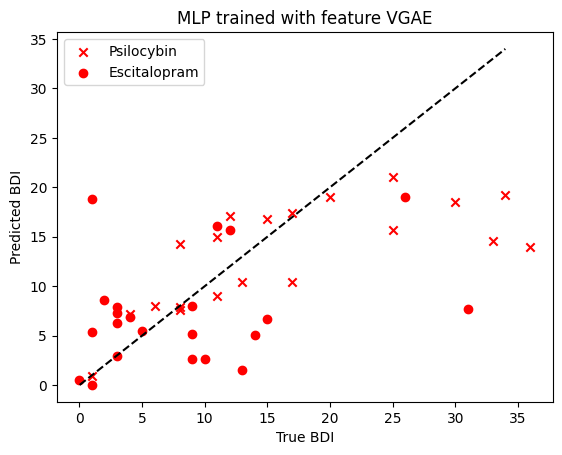

Average R-squared: 0.2914853732976499
Average MAE: 5.83431882366745


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error

r2_scores = []
mae_scores = []
r_scores = []

l1 = []
l2 = []

colors = ['red', 'blue', 'green', 'orange', 'purple']

for fold in best_set:
    l1.extend([t.item() for t in fold[0]])
    l2.extend([t.item() for t in fold[1]])


print(r2_score(l1, l2))
print(pearsonr(l1, l2))
print(mean_absolute_error(l1,l2))

print()

total_true = []
total_pred = []
total_drug = []
total_base = []

for i, (true, pred, base) in enumerate(best_set):
    true = [t.item() for t in true]
    pred = [p.item() for p in pred]
    drug = [d[0].item() for d in base]
    base = [d[1].item() for d in base]
    
    total_true.extend(true)
    total_pred.extend(pred)
    total_drug.extend(drug)
    total_base.extend(base)
    # Calculate R-squared (Pearson correlation coefficient)
    r2 = r2_score(true, pred)
    r2_scores.append(r2)

    r_scores.append(pearsonr(true, pred))
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(true, pred)
    mae_scores.append(mae)
    
    for t, p, d in zip(true, pred, drug):
        marker = 'x' if d == -1 else 'o'
        plt.scatter(t, p, color='red', marker=marker)

        
min_val = min(min(true), min(pred))
max_val = max(max(true), max(pred))
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
        
plt.xlabel('True BDI')
plt.ylabel('Predicted BDI')
plt.title('MLP trained with feature VGAE')
plt.legend(['Psilocybin', 'Escitalopram'])
plt.savefig('mlp_feature_vgae.png', bbox_inches='tight')
plt.show()

# Calculate average R-squared and MAE across all folds
avg_r2 = np.mean(r2_scores)
avg_mae = np.mean(mae_scores)

import csv
head = ['r2', 'pearson_r', 'pval']
with open('use_nf.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(head)

    # Write the data rows
    for i in range(5):
        writer.writerow([r2_scores[i], r_scores[i][0], r_scores[i][1]])
        
# Specify the filename for the CSV file
filename = 'feature-vgae-full-val-results-ica.csv'

# Create a list of rows with headers
rows = [['true_post_bdi', 'predicted_post_bdi', 'drug (1 for psilo)', 'base_bdi']]
for true, pred, drug, base in zip(total_true, total_pred, total_drug, total_base):
    rows.append([true, pred, drug, base])

# Write the rows to the CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)
        
print('Average R-squared:', avg_r2)
print('Average MAE:', avg_mae)